In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

In [2]:
from scipy.stats import norm, t
import torch
import MI
import marginal as mg
import bvcopula
from vine import CVine
import pickle as pkl
from train import conf
import select_copula
import utils

import matplotlib.pyplot as plt
import numpy as np

NSamp=10000
device = torch.device('cuda:1')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)

In [50]:
Nvar=6
rhos = np.ones(NSamp)*0.7
dfs = np.exp(5*np.linspace(0,1,NSamp))+1

HRgS = utils.student_H(rhos,dfs,Nvar)/np.log(2)
HRgS.mean()

3.458549205332889

In [52]:
utils.student_H(rhos[0],1e10,Nvar)/np.log(2)

3.2575835673702214

In [37]:
samples = utils.student_rvs(Nvar,rhos,dfs,500)
samples = np.einsum("ij...->ji...",samples)
Hrs = utils.student_logprob(samples,rhos,dfs).mean(axis=-1)
H=[]
for i in range(100):
    perm = np.random.permutation(np.arange(len(rhos)))
    H.append(np.exp(utils.student_logprob(samples,rhos[perm],dfs[perm])))
H = np.stack(H)
Hr = np.log(H.mean(axis=0)).mean(axis=-1)
integral = ((Hrs.mean()-Hr.mean(),Hrs.mean())/np.log(2))#,Hrs.std(),Hr.std())
# (student_log_pdf(y0,rhos,dfs).mean()-np.log(H.mean(axis=0)).mean())/np.log(2)
integral

array([ 0.05693386, -4.13419637])

In [31]:
y = utils.student_rvs(Nvar,rhos,dfs,1).squeeze()
y0 = np.zeros_like(y)
for i in range(y.shape[0]):
    y0[i] = t.cdf(y[i],df=dfs[i])

In [32]:
KSG = mg.revised_mi(x.reshape((*x.shape,1)),y0,)
KSG

(0.009120063293994713, -2.590284314602333)

In [33]:
N = Nvar
#redirect logging here
exp_pref='benchmark'
data_layers = [torch.tensor(y0).float().to(device)]
copula_layers = []
for m in range(0,N-1):
    out_dir = f'{conf.path2outputs}/{exp_pref}/layer{m}'
    copulas, layer = [], []
    for n in range(1,N-m):
        print(m,n+m)
        samples = data_layers[-1][...,[n,0]]
        waic, model = bvcopula.infer([bvcopula.GaussianCopula_Likelihood(),
                                      bvcopula.GumbelCopula_Likelihood(rotation='0°'),
                                      bvcopula.GumbelCopula_Likelihood(rotation='180°')],
                                     train_x,samples,device=device)
#         (likelihoods, waic) = select_copula.select_with_heuristics(x,samples.cpu().numpy(),device,exp_pref,out_dir,m,n+m,
#                                                                   train_x=train_x, train_y=samples)
#         weights_file = f"{out_dir}/model_{exp_pref}_{m}-{m+n}.pth"
#         model = utils.get_model(weights_file, likelihoods, device) 
        with torch.no_grad():
            f = model(train_x).mean
            copula = model.likelihood.get_copula(f)
            copulas.append(copula)
            layer.append(copula.ccdf(samples))
    data_layers.append(torch.stack(layer,dim=-1))
    copula_layers.append(copulas)

0 1
0 2
1 2


In [34]:
vine_trained = CVine(copula_layers,train_x,device=device)
# with open(f"{home}vine.pkl","wb") as f:
#     pkl.dump([y,vine_trained],f)

In [35]:
# with open(f"{home}vine.pkl","rb") as f:
#     [y0,vine_trained] = pkl.load(f)

In [36]:
subvine = vine_trained.create_subvine(torch.arange(0,NSamp,50))
%time CopulaGP = subvine.stimMI(sem_tol=0.01)

CopulaGP

CPU times: user 7.56 s, sys: 6.93 s, total: 14.5 s
Wall time: 2.89 s


(tensor([0.0198], device='cuda:1'),
 tensor(0.0139, device='cuda:1'),
 tensor([2.5988], device='cuda:1'),
 tensor(0.0098, device='cuda:1'))

In [3]:
results_file = f"{home}/MI_dump.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
i = list(range(len(results)))
for k in range(3):
    i[3+k]=6+k
    i[6+k]=3+k
results = [results[j] for j in i]
results[0]

[[2, 10000],
 [0.5067255537165143, 0.4864134192466736, 0.42834700404217757],
 [0.04297121571048656,
  0.011314034461975098,
  -0.012989229121354083,
  -0.00630323777436247],
 [array([[0.82482911, 0.50218122],
         [0.44185201, 0.54418388],
         [0.22750769, 0.13326953],
         ...,
         [0.03646357, 0.02781185],
         [0.44690433, 0.06313422],
         [0.03237183, 0.11144026]]),
  array([0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7]),
  array([  2.        ,   2.00050018,   2.0010006 , ..., 149.2648053 ,
         149.33896365, 149.4131591 ])]]

In [4]:
Ns = np.array([res[0][0] for res in results])
Ns

array([2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6])

In [28]:
torch.tensor([88.]).exp()

tensor([1.6516e+38])

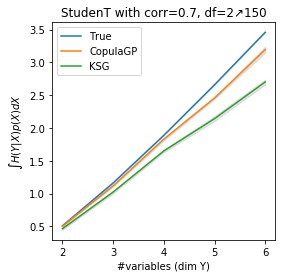

In [5]:
plt.figure(figsize=(4,4))
def line(H,label):
    NN = Ns.max()+1-Ns.min()
    A = np.empty((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        A[1,i] = H[Ns==n].mean()
        A[2,i] = H[Ns==n].std()
    plt.plot(A[0],A[1],label=label)
    plt.fill_between(A[0],A[1]-A[2],A[1]+A[2],color='grey',alpha=0.2)
for i,label in enumerate(["True","CopulaGP","KSG"]):
    line(np.array([res[1][i] for res in results]),label)
plt.title("StudenT with corr=0.7, df=2↗150")
plt.xlabel("#variables (dim Y)")
plt.ylabel("$\int H(Y|X)p(X)dX$")
plt.legend();

In [18]:
%time MINEs = [MI.train_MINE(res[-1][0],H=200) for res in results]

CPU times: user 4min 49s, sys: 3.98 s, total: 4min 53s
Wall time: 4min 57s


In [19]:
MINEs200 = MINEs

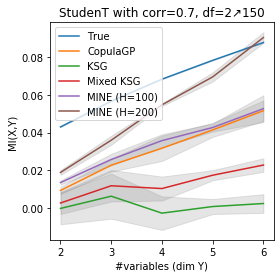

In [22]:
plt.figure(figsize=(4,4))
for i,label in enumerate(["True","CopulaGP","KSG","Mixed KSG"]):
    line(np.array([res[2][i] for res in results]),label)
# line(np.array(MINEs20)/np.log(2),"MINE (H=20)")
# line(np.array(MINEs50)/np.log(2),"MINE (H=50)")
line(np.array(MINEs100)/np.log(2),"MINE (H=100)")
line(np.array(MINEs200)/np.log(2),"MINE (H=200)")
plt.title("StudenT with corr=0.7, df=2↗150")
plt.xlabel("#variables (dim Y)")
plt.ylabel("MI(X,Y)")
plt.legend();

In [174]:

# %time plot_loss=train()